In [26]:
# load data
import glob
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer # https://realpython.com/k-means-clustering-python/

# modelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report

# load/save model
import pickle

# Load Data

- input: -
- output: `X, y`

In [3]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = glob.glob(path)
    images = np.array([import_image(file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [5]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

X = np.empty((0, 224, 224, 3), np.uint8)
y = np.empty((0))

for character in hanacaraka:
    training_path = "../Dataset/train/" + character + "/*.png"
    testing_path = "../Dataset/val/" + character + "/*.png"
    
    temp_X_train, temp_y_train = import_data(character, training_path)
    temp_X_test, temp_y_test = import_data(character, testing_path)
    
    print("Ukuran karakter", character, ":", temp_X_train.shape[0] + temp_X_test.shape[0])
    
    X = np.append(X, temp_X_train, axis=0)
    y = np.append(y, temp_y_train, axis=0)
    X = np.append(X, temp_X_test, axis=0)
    y = np.append(y, temp_y_test, axis=0)


Ukuran karakter ba  : 138
Ukuran karakter ca  : 132
Ukuran karakter da  : 132
Ukuran karakter dha  : 132
Ukuran karakter ga  : 132
Ukuran karakter ha  : 126
Ukuran karakter ja  : 132
Ukuran karakter ka  : 132
Ukuran karakter la  : 132
Ukuran karakter ma  : 132
Ukuran karakter na  : 132
Ukuran karakter nga  : 126
Ukuran karakter nya  : 132
Ukuran karakter pa  : 132
Ukuran karakter ra  : 132
Ukuran karakter sa  : 132
Ukuran karakter ta  : 132
Ukuran karakter tha  : 132
Ukuran karakter wa  : 132
Ukuran karakter ya  : 132


In [6]:
# Ukuran keseluruhan data
print("Ukuran data:", X.shape[0])

Ukuran data: 2634


<AxesSubplot:ylabel='count'>

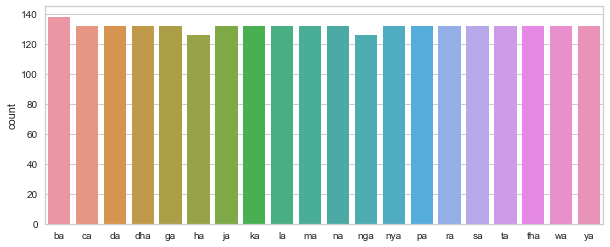

In [8]:
plt.figure(figsize=(10,4))
sns.countplot(x=y)

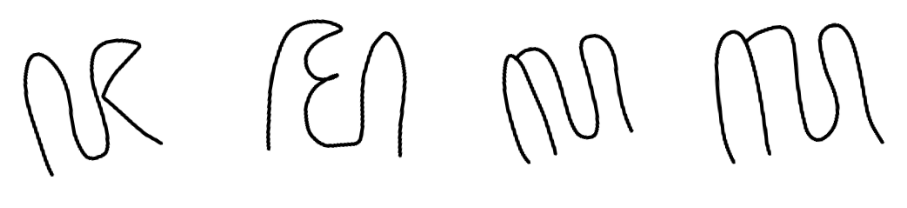

In [9]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X[np.random.randint(0, 2154), 0:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Preprocessing

- input: `X`
- output: `X_prep`

kind of image preprocessing
- grayscaling (o)
- resizing (x)
- cropping (x)
- binarization (o)
- negative (x)
- skeletonization/thinning (o)
- noise reduction (x)
- sharpening (o)

In [11]:
def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image
    
def thresholding(image):
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return image

def resizing(image, size=128):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

# https://soumyapatilblogs.medium.com/image-filtering-using-opencv-66b67e1bd968
def denoising(image):
    #image = cv2.fastNlMeansDenoisingColored(img, None, 5, 5, 7, 21)
    image = cv2.medianBlur(image, 5)
    return image

def sharpening(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    #kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    return image

def preprocessing(image, size=128):
    image = resizing(image)
    return image

In [12]:
X_prep = []

for i in range(X.shape[0]) :
    X_prep.append(preprocessing(X[i]))
    
X_prep = np.array(X_prep, dtype=np.uint8)

In [13]:
print("Dimensi data:", X_prep.shape)

Dimensi data: (2634, 128, 128, 3)


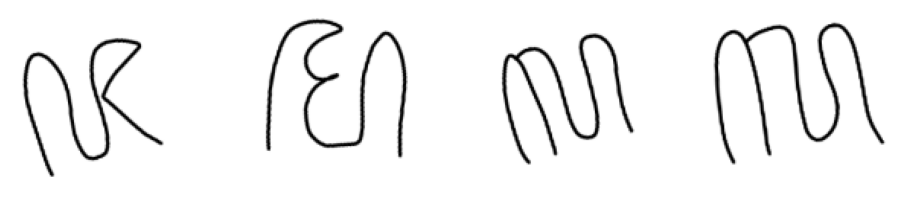

In [14]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X_prep[np.random.randint(0, 2154), 0:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Feature Extraction

- input: `X_prep`
- output: `X_feature`

### Extract sift descriptors 

In [15]:
def extract_sift_features(list_image):

    image_descriptors = []
    sift = cv2.SIFT_create()
    for image in list_image:
        _, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)

    return image_descriptors

def split_all_descriptors(image_descriptors):
    all_descriptors = []
    for descriptor in image_descriptors:
        if descriptor is not None:
            for des in descriptor:
                all_descriptors.append(des)
    
    return np.array(all_descriptors)

In [16]:
image_descriptors = extract_sift_features(X_prep)
all_descriptors = split_all_descriptors(image_descriptors)

In [17]:
all_descriptors.shape

(68109, 128)

### Create bow of descriptor using cluster

In [64]:
ks = [70, 100, 130, 160, 200, 250]
sse = []
silhouette_coefficients = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(all_descriptors)     
    sse.append(kmeans.inertia_)
    score = silhouette_score(all_descriptors, kmeans.labels_)
    silhouette_coefficients.append(score)

Text(0, 0.5, 'Silhouette Coefficient')

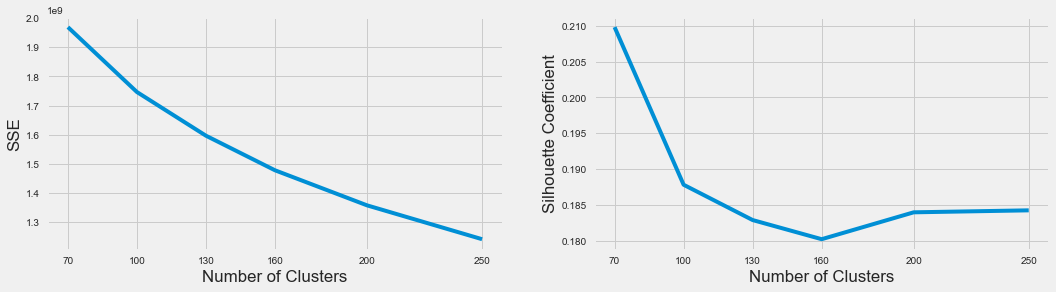

In [65]:
fig = plt.figure(figsize=(16, 4))
plt.style.use("fivethirtyeight")

fig.add_subplot(1, 2, 1)
plt.plot(ks, sse)
plt.xticks(ks)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

fig.add_subplot(1, 2, 2)
plt.plot(ks, silhouette_coefficients)
plt.xticks(ks)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")

In [66]:
def kmeans_bow(all_descriptors, num_cluster):
    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    #if not os.path.isfile('bow_dictionary.pkl'):
    pickle.dump(bow_dict, open('bow_dictionary.pkl', 'wb'))

    return kmeans, bow_dict

In [67]:
num_cluster = 160
kmeans, bow = kmeans_bow(all_descriptors, num_cluster)

### Create features from bow

In [68]:
def create_feature_bow(image_descriptors, bow, num_cluster):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster, dtype=float)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], bow)
            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1.0
        X_features.append(features)

    return np.array(X_features)

In [69]:
X_feature = create_feature_bow(image_descriptors, bow, num_cluster)

print("Dimensi data fitur:", X_feature.shape)

Dimensi data fitur: (2634, 160)


# Classification

- input: `X_feature, y`
- output: -

In [70]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

In [71]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=42)

print("Ukuran data training:", X_train.shape[0])
print("Ukuran data testing:", X_test.shape[0])

Ukuran data training: 2107
Ukuran data testing: 527


## KNN

In [72]:
knn_params = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
knn_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params, cv=5, verbose=3)

In [73]:
knn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.742 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.765 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.784 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.777 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.774 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.713 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;, score=0.739 total time=   0.0s
[CV 3/5] END .....................n_neighbors=3;, score=0.720 total time=   0.0s
[CV 4/5] END .....................n_neighbors=3;, score=0.746 total time=   0.0s
[CV 5/5] END .....................n_neighbors=3;, score=0.736 total time=   0.0s
[CV 1/5] END .....................n_neighbors=5;, score=0.668 total time=   0.0s
[CV 2/5] END .....................n_neighbors=5;

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             verbose=3)

In [74]:
print("Model terbaik:", knn_cv.best_estimator_)
print("Score terbaik:", knn_cv.best_score_)

Model terbaik: KNeighborsClassifier(n_neighbors=1)
Score terbaik: 0.7684051738694825


In [75]:
cv_results_df = pd.DataFrame(knn_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1,{'n_neighbors': 1},1,0.768405,0.014593
3,{'n_neighbors': 3},2,0.730901,0.012329
5,{'n_neighbors': 5},3,0.681537,0.012784
7,{'n_neighbors': 7},4,0.634078,0.014053
9,{'n_neighbors': 9},5,0.584731,0.020460
11,{'n_neighbors': 11},6,0.544858,0.024741
13,{'n_neighbors': 13},7,0.514006,0.023461
15,{'n_neighbors': 15},8,0.487904,0.021169
17,{'n_neighbors': 17},9,0.456579,0.023505


In [76]:
y_pred = knn_cv.predict(X_test)

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.93      0.67      0.78        21
          ca       1.00      0.79      0.89        34
          da       0.89      0.89      0.89        19
         dha       0.97      0.78      0.86        40
          ga       0.74      0.68      0.71        25
          ha       0.82      0.39      0.53        23
          ja       0.96      0.93      0.95        29
          ka       0.95      0.76      0.84        25
          la       0.68      0.50      0.58        26
          ma       1.00      0.93      0.96        28
          na       0.85      0.88      0.86        25
         nga       0.77      0.93      0.84        29
         nya       1.00      0.70      0.83        27
          pa       0.30      0.84      0.44        19
          ra       0.43      0.86      0.57        29
          sa       0.88      0.64      0.74        22
          ta       0.95      0.71      0.82        28
         tha       1.00    

### SVM

In [78]:
svm_params = {
    'C': [0.5, 1, 3, 6, 10],
    'gamma': ['scale', 'auto', 0.003, 0.005, 0.009]
}
svm_cv = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=svm_params, cv=5, verbose=3)

In [79]:
svm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ................C=0.5, gamma=scale;, score=0.855 total time=   0.4s
[CV 2/5] END ................C=0.5, gamma=scale;, score=0.882 total time=   0.4s
[CV 3/5] END ................C=0.5, gamma=scale;, score=0.865 total time=   0.4s
[CV 4/5] END ................C=0.5, gamma=scale;, score=0.860 total time=   0.4s
[CV 5/5] END ................C=0.5, gamma=scale;, score=0.862 total time=   0.4s
[CV 1/5] END .................C=0.5, gamma=auto;, score=0.851 total time=   0.4s
[CV 2/5] END .................C=0.5, gamma=auto;, score=0.882 total time=   0.4s
[CV 3/5] END .................C=0.5, gamma=auto;, score=0.865 total time=   0.4s
[CV 4/5] END .................C=0.5, gamma=auto;, score=0.857 total time=   0.4s
[CV 5/5] END .................C=0.5, gamma=auto;, score=0.862 total time=   0.4s
[CV 1/5] END ................C=0.5, gamma=0.003;, score=0.808 total time=   0.3s
[CV 2/5] END ................C=0.5, gamma=0.003

[CV 2/5] END .................C=10, gamma=scale;, score=0.927 total time=   0.4s
[CV 3/5] END .................C=10, gamma=scale;, score=0.907 total time=   0.4s
[CV 4/5] END .................C=10, gamma=scale;, score=0.917 total time=   0.4s
[CV 5/5] END .................C=10, gamma=scale;, score=0.912 total time=   0.4s
[CV 1/5] END ..................C=10, gamma=auto;, score=0.900 total time=   0.4s
[CV 2/5] END ..................C=10, gamma=auto;, score=0.927 total time=   0.4s
[CV 3/5] END ..................C=10, gamma=auto;, score=0.907 total time=   0.4s
[CV 4/5] END ..................C=10, gamma=auto;, score=0.917 total time=   0.4s
[CV 5/5] END ..................C=10, gamma=auto;, score=0.914 total time=   0.4s
[CV 1/5] END .................C=10, gamma=0.003;, score=0.893 total time=   0.2s
[CV 2/5] END .................C=10, gamma=0.003;, score=0.912 total time=   0.2s
[CV 3/5] END .................C=10, gamma=0.003;, score=0.917 total time=   0.2s
[CV 4/5] END ...............

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.5, 1, 3, 6, 10],
                         'gamma': ['scale', 'auto', 0.003, 0.005, 0.009]},
             verbose=3)

In [80]:
print("Model terbaik:", svm_cv.best_estimator_)
print("Score terbaik:", svm_cv.best_score_)

Model terbaik: SVC(C=10, gamma='auto')
Score terbaik: 0.9131463115353874


In [81]:
cv_results_df = pd.DataFrame(svm_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10_auto,"{'C': 10, 'gamma': 'auto'}",1,0.913146,0.008821
10_scale,"{'C': 10, 'gamma': 'scale'}",2,0.912671,0.008800
3_scale,"{'C': 3, 'gamma': 'scale'}",3,0.912198,0.010046
3_auto,"{'C': 3, 'gamma': 'auto'}",3,0.912198,0.010046
6_auto,"{'C': 6, 'gamma': 'auto'}",5,0.911252,0.009752
6_scale,"{'C': 6, 'gamma': 'scale'}",5,0.911252,0.009752
6_0.005,"{'C': 6, 'gamma': 0.005}",7,0.910303,0.007659
10_0.005,"{'C': 10, 'gamma': 0.005}",8,0.910303,0.009131
3_0.005,"{'C': 3, 'gamma': 0.005}",9,0.909351,0.009392


In [82]:
y_pred = svm_cv.predict(X_test)

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.86      0.86      0.86        21
          ca       1.00      0.94      0.97        34
          da       1.00      0.95      0.97        19
         dha       0.97      0.97      0.97        40
          ga       0.85      0.92      0.88        25
          ha       0.76      0.70      0.73        23
          ja       1.00      1.00      1.00        29
          ka       1.00      0.92      0.96        25
          la       0.85      0.88      0.87        26
          ma       1.00      1.00      1.00        28
          na       0.93      1.00      0.96        25
         nga       0.96      0.90      0.93        29
         nya       0.90      1.00      0.95        27
          pa       0.59      0.89      0.71        19
          ra       0.93      0.86      0.89        29
          sa       0.92      1.00      0.96        22
          ta       1.00      0.93      0.96        28
         tha       1.00    